In [1]:
from typing import Dict, List, Tuple
import torch
import numpy as np
import gym
import json
from plotly.subplots import make_subplots
from agent.DQN_Agent import *
from Logger import *
from environment.DiscreteEnvironment import DiscreteSimpleEnvironment

%load_ext autoreload
%autoreload 2

## Set environment and agent parameters

In [3]:
env_arguments = {
"alpha":1,
"beta":1,
"min_temp" : 16,
"max_temp" : 21,
"action_dim": 100,
"modelname":'CELLS_v1.fmu',
"simulation_path":  r'C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\EnergyPlus_simulations\simple_simulation',
"param_list": ['Tair', 'RH', 'Tmrt', 'Tout', 'Qheat', 'Occ'],
"days": 151,  
"hours": 24,  
"minutes": 60,
"seconds": 60,
"ep_timestep": 6
}

env = DiscreteSimpleEnvironment(param_list=['Tair', 'RH', 'Tmrt', 'Tout', 'Qheat', 'Occ'],
alpha=1,
beta=1,
min_temp=16,
max_temp=21,
discrete_action_dim=100,
modelname='CELLS_v1.fmu',
simulation_path=r'C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\EnergyPlus_simulations\simple_simulation',
days=151,
hours=24,
minutes=60,
seconds=60,
ep_timestep=6)

agent_arguments = {
"memory_size": [1000],
"batch_size": [32],
"actor_update":[2],
"target_update": [100],
"epsilon_decay": [1 / 20000],
"max_epsilon": [1],
"min_epsilon":  [0.0],
"lr":[1e-3],
"gamma": [0.99],
"inside_dim": [128],
"num_hidden_layers": [1],
"seed": [778]
}

def cumulative_reward(data:pd.DataFrame) -> float:
    return np.cumsum(np.array(data["Reward"]))[-1]

SELECTED ENV ACTION 16.404040404040405
Iteration0
SELECTED ENV ACTION 18.828282828282827
Iteration1000
SELECTED ENV ACTION 20.747474747474747
Iteration2000
SELECTED ENV ACTION 18.67676767676768
Iteration3000
SELECTED ENV ACTION 18.97979797979798
Iteration4000


'C:\\Users\\Harold\\Desktop\\ENAC-Semester-Project\\DIET_Controller\\logs\\simple_simulation/results/DQN_Agent/2022_6_9/results_2022_6_9_13_30'

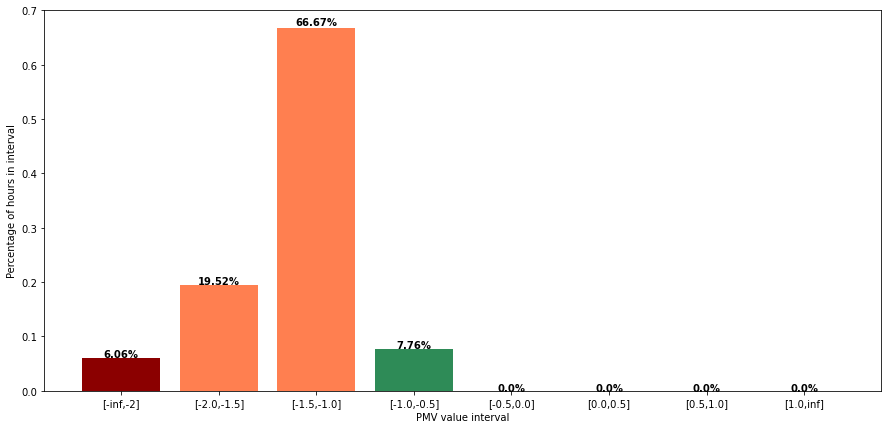

In [4]:
from utils import all_combinations_list

best_reward = -np.inf
best_path = ""

logging_path = r"C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\logs\simple_simulation"

for curr_agent_arguments in all_combinations_list(agent_arguments):

    agent = DQNAgent(env).from_dict(dict_arguments=curr_agent_arguments)
    results_path, summary_df = agent.train(logging_path= logging_path, num_episodes=1, num_iterations=5000 ,log=True)
    total_cum_reward = cumulative_reward(summary_df)
    if total_cum_reward > best_reward:
        best_reward = total_cum_reward
        best_path = results_path
  

best_path



In [11]:
l = [[{'secondary_y': False}], [{'secondary_y': True}], [{'secondary_y': False}], [{'secondary_y': True}], [{'secondary_y': True}], [{'secondary_y': False}], [{'secondary_y': False}], [{'secondary_y': False}]]

len(l)

8

In [4]:
from utils import assess_performance

assess_performance(r'C:/Users/Harold/Desktop/ENAC-Semester-Project/DIET_Controller/results/2022_4_30/results_2022_4_30_14_54/')

{WindowsPath('C:/Users/Harold/Desktop/ENAC-Semester-Project/DIET_Controller/results/2022_4_30/results_2022_4_30_14_54/experiments_csv/experiments_results_1.csv'): 0.5350667456999525,
 WindowsPath('C:/Users/Harold/Desktop/ENAC-Semester-Project/DIET_Controller/results/2022_4_30/results_2022_4_30_14_54/experiments_csv/experiments_results_2.csv'): 0.5619388214374257,
 WindowsPath('C:/Users/Harold/Desktop/ENAC-Semester-Project/DIET_Controller/results/2022_4_30/results_2022_4_30_14_54/experiments_csv/experiments_results_summary.csv'): 0.560152310902544}

In [15]:
# Example of how to use the function: 

from utils import search_paths

searching_directory = r"C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller"

conditions={
    "is_test":["=",False],
    "num_iterations": ["=",21744], # to only have have trainings where the full simulation was used
    "num_episodes":["=",3],
    "alpha":["=",1],
    "beta":["=",1],
    "num_hidden_layers":[">",2]
}

path_list, best_reward_path, best_heat_path = search_paths(searching_directory,conditions=conditions, top_k=10)

best_reward_path, best_heat_path

(array([WindowsPath('C:/Users/Harold/Desktop/ENAC-Semester-Project/DIET_Controller/results/2022_4_30/results_2022_4_30_16_20/env_params_2022_4_30_16_20.json'),
        WindowsPath('C:/Users/Harold/Desktop/ENAC-Semester-Project/DIET_Controller/results/2022_4_30/results_2022_4_30_15_39/env_params_2022_4_30_15_39.json'),
        WindowsPath('C:/Users/Harold/Desktop/ENAC-Semester-Project/DIET_Controller/results/2022_4_30/results_2022_4_30_16_10/env_params_2022_4_30_16_10.json'),
        WindowsPath('C:/Users/Harold/Desktop/ENAC-Semester-Project/DIET_Controller/results/2022_4_30/results_2022_4_30_15_50/env_params_2022_4_30_15_50.json'),
        WindowsPath('C:/Users/Harold/Desktop/ENAC-Semester-Project/DIET_Controller/results/2022_4_30/results_2022_4_30_22_49/env_params_2022_4_30_22_49.json'),
        WindowsPath('C:/Users/Harold/Desktop/ENAC-Semester-Project/DIET_Controller/results/2022_4_30/results_2022_4_30_22_31/env_params_2022_4_30_22_31.json'),
        WindowsPath('C:/Users/Harold/Des

In [2]:
import pandas as pd

In [11]:
d = True

if(d == False):
    print("bite")

In [8]:
df = pd.read_csv(r"C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\results\2022_5_10\results_2022_5_10_15_0\experiments_csv\experiments_results_1.csv")

In [37]:
from pathlib import Path
import json

searching_directory = r"C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\results\DQN_Agent"

for path in Path(searching_directory).glob("**/*json"):
        
        if os.path.getsize(path) > 0 and str(path).__contains__("env_params"):
                f = open(path,"r")
                log_dict = json.load(f)
                closed= False
                if not("discrete_action_dim" in log_dict.keys()) or (log_dict["action_dim"] != 1):
                    print(path)
                    closed=True
                    log_dict["discrete_action_dim"] = log_dict["action_dim"]
                    log_dict["action_dim"] = 1
                    f.close()

                    os.remove(path)
                    with open(path, 'w') as f:
                        f.write(json.dumps(log_dict,indent=True))

                if not(closed):
                    f.close()


# Testing performance pipeline

Iteration0
Iteration1000
Iteration2000
Iteration3000
Iteration4000
Iteration5000
Iteration6000
Iteration7000
Iteration8000
Iteration9000
Iteration10000
Iteration11000
Iteration12000
Iteration13000
Iteration14000
Iteration15000
Iteration16000
Iteration17000
Iteration18000
Iteration19000
Iteration20000
Iteration21000
Iteration0
Iteration1000
Iteration2000
Iteration3000
Iteration4000
Iteration5000
Iteration6000
Iteration7000
Iteration8000
Iteration9000
Iteration10000
Iteration11000
Iteration12000
Iteration13000
Iteration14000
Iteration15000
Iteration16000
Iteration17000
Iteration18000
Iteration19000
Iteration20000
Iteration21000
Iteration0
Iteration1000
Iteration2000
Iteration3000
Iteration4000
Iteration5000
Iteration6000
Iteration7000
Iteration8000
Iteration9000
Iteration10000
Iteration11000
Iteration12000
Iteration13000
Iteration14000
Iteration15000
Iteration16000
Iteration17000
Iteration18000
Iteration19000
Iteration20000
Iteration21000
Iteration0
Iteration1000
Iteration2000
Iteration3

NameError: name 'env' is not defined

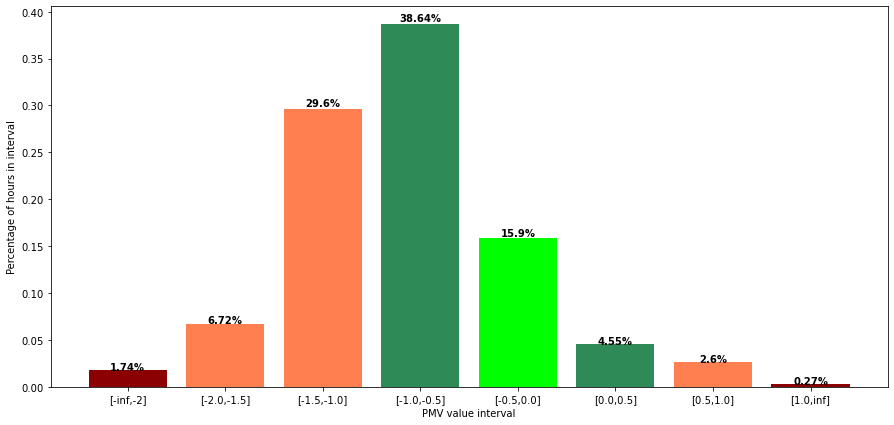

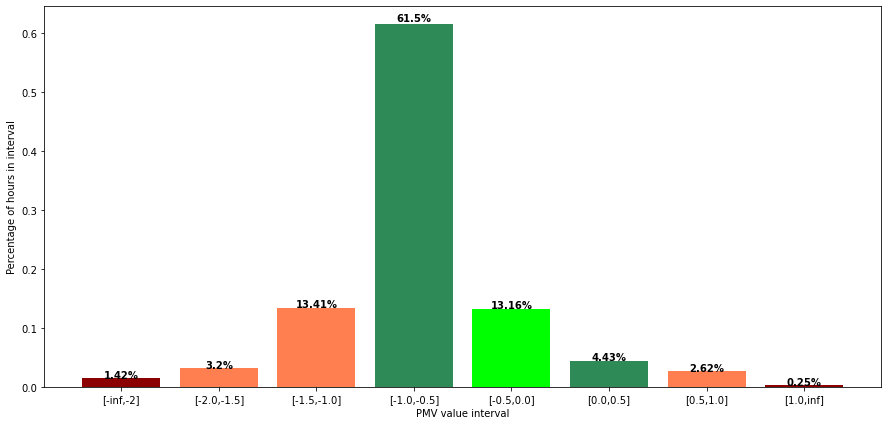

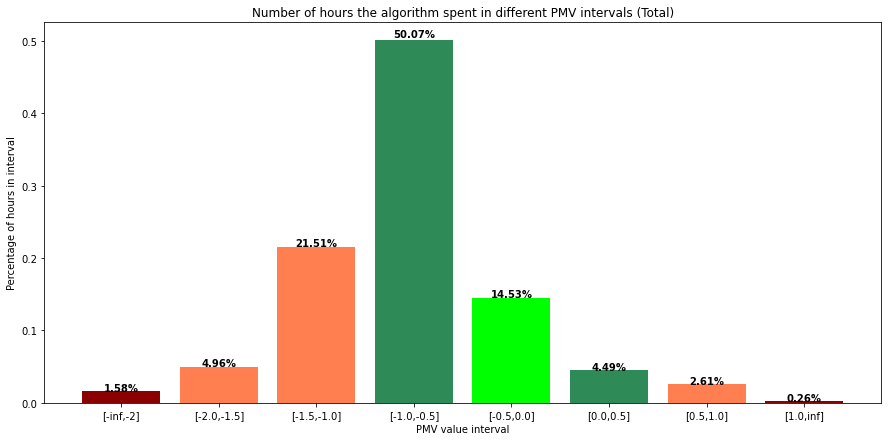

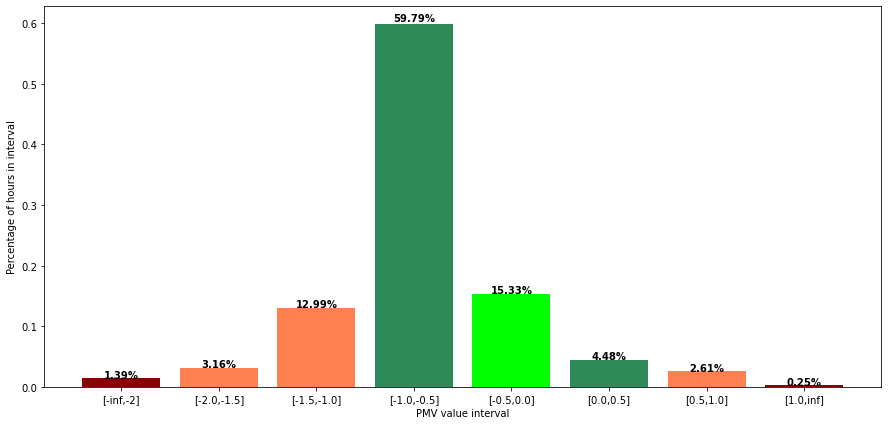

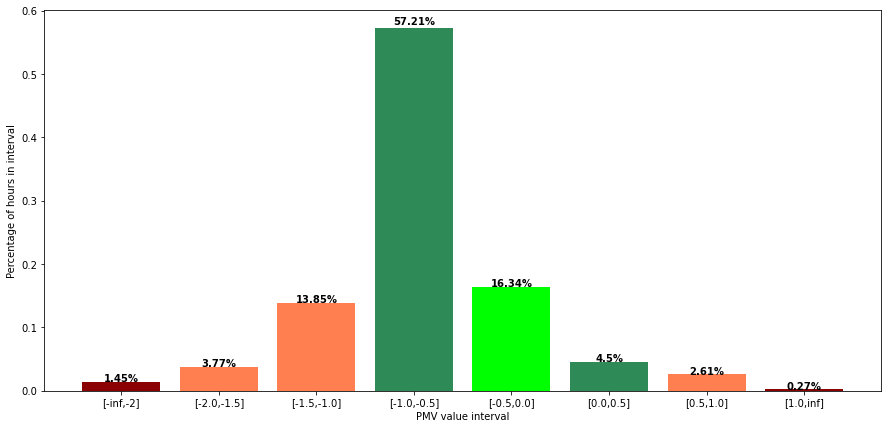

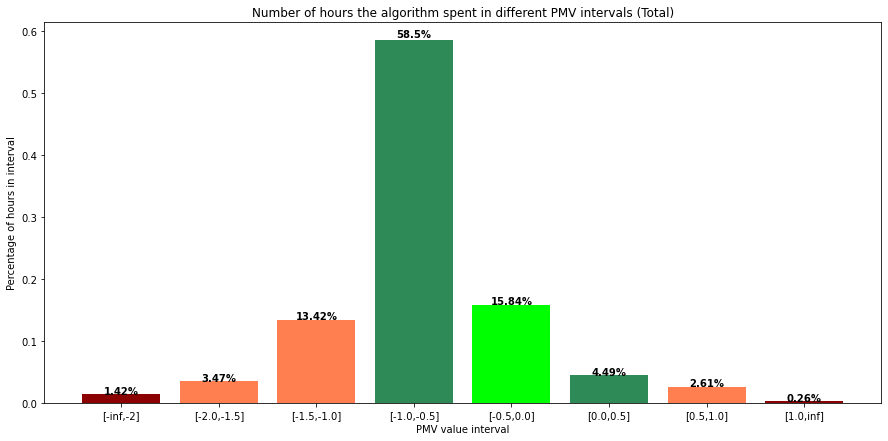

In [6]:
import Performance

env = DiscreteSimpleEnvironment(param_list=['Tair', 'RH', 'Tmrt', 'Tout', 'Qheat', 'Occ'],
alpha=1,
beta=1,
min_temp=16,
max_temp=21,
discrete_action_dim=100,
modelname='CELLS_v1.fmu',
simulation_path=r'C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\EnergyPlus_simulations\simple_simulation',
days=151,
hours=24,
minutes=60,
seconds=60,
ep_timestep=6)

agent_arguments = {
"memory_size": [1000],
"batch_size": [32],
"target_update": [100],
"epsilon_decay": [1 / 20000],
"max_epsilon": [1],
"min_epsilon":  [0.0],
"gamma": [0.99],
"inside_dim": [128],
"num_hidden_layers": [1],
"seed": [778]
}


parameter = ("seed", [775,776])

logging_path = r"C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\logs\simple_simulation"

utility_function = Performance.cumulative_reward

agent = DQNAgent(env=env)


dispersion,risk = Performance.across_runs(agent=agent, agent_arguments=agent_arguments, parameter=parameter,agent_name="DQN_Agent",
    logging_path=logging_path, num_episodes=2, num_iterations=env.numsteps, utility_function=utility_function,alpha=0.05)


